# Exploring overfitting

### Imports

In [8]:
import numpy as np

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
sns.set_style("whitegrid")

from sklearn.linear_model import LogisticRegression

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

### Settings

In [27]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
# boundary of the graph
GRID_PADDING = 0.5
GRID_STEP = 0.01
# number of iterations of the neural network
N_EPOCHS = 500

### Create artificial dataset

In [28]:
# X, y = make_moons(n_samples = N_SAMPLES, noise=0.3, random_state=42)
# X, y = make_circles(n_samples=N_SAMPLES, factor=.1, noise=.3)
# X, y = make_classification(	n_samples=N_SAMPLES, n_features=2, n_redundant=0,
#         random_state=1, n_clusters_per_class=2)

X1, y1 = make_classification(	n_samples=int(N_SAMPLES/2), n_features=2, n_redundant=0, flip_y=0.4,
        random_state=1, n_clusters_per_class=2)
X2, y2 = make_classification(	n_samples=int(N_SAMPLES/2), n_features=2, n_redundant=0, flip_y=0.3,
        random_state=500, n_clusters_per_class=2)

# X1, y1 = make_classification(	n_samples=int(N_SAMPLES/2), n_features=2, n_redundant=0, flip_y=0.3, scale=2.0, 
#         random_state=1, n_clusters_per_class=2, shift=[-2,-4])
# X2, y2 = make_classification(	n_samples=int(N_SAMPLES/2), n_features=2, n_redundant=0, flip_y=0.3, scale=1.5,
#         random_state=2, n_clusters_per_class=2, shift=[2,2])
# X3, y3 = make_classification(	n_samples=int(N_SAMPLES/2), n_features=2, n_redundant=0, flip_y=0.3, scale=2.0, 
#         random_state=3, n_clusters_per_class=2, shift=[-1,1])

X = np.concatenate((X1,X2),axis = 0)
y = np.concatenate((y1,y2),axis = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=42)

### Definition of grid

In [29]:
x_min, x_max = X[:, 0].min() - GRID_PADDING, X[:, 0].max() + GRID_PADDING
y_min, y_max = X[:, 1].min() - GRID_PADDING, X[:, 1].max() + GRID_PADDING
XX, YY = np.meshgrid(np.arange(x_min, x_max, GRID_STEP), np.arange(y_min, y_max, GRID_STEP))

### Auxiliary plotting function

In [30]:
def make_plot(XX, YY, preds, plot_name, file_name):
    plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.set_xlim([x_min,x_max])
    axes.set_ylim([y_min,y_max])
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=20)
    plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 0.6, cmap=cm.Spectral)
    plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=50, cmap=plt.cm.Spectral, edgecolors='black')
    # plt.savefig(file_name)
    # plt.close()

### Visualization of the data set

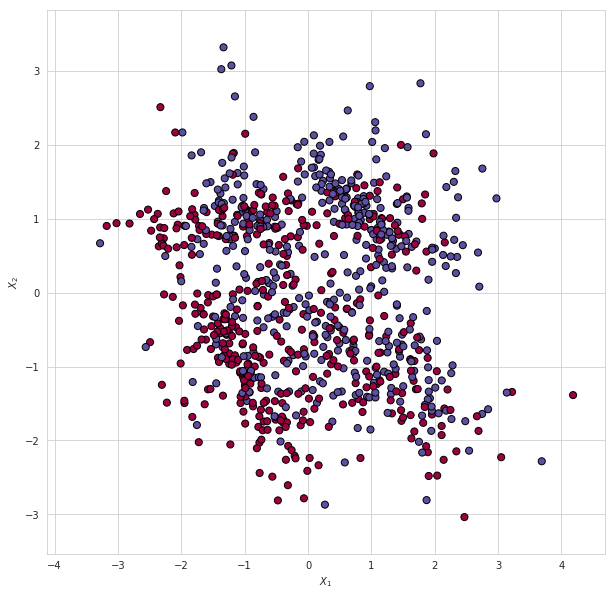

In [31]:
plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
axes.set(xlabel="$X_1$", ylabel="$X_2$")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=50, cmap=plt.cm.Spectral, edgecolors='black');
# plt.savefig("dataset.png")

### Logistic regression (high bias)

In [32]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)
train_error = accuracy_score(y_train, y_train_pred)
test_error = accuracy_score(y_test, y_test_pred)
print("Train accuracy: " + str(train_error))
print("Test accuracy: " + str(test_error))

Train accuracy: 0.6533333333333333
Test accuracy: 0.7


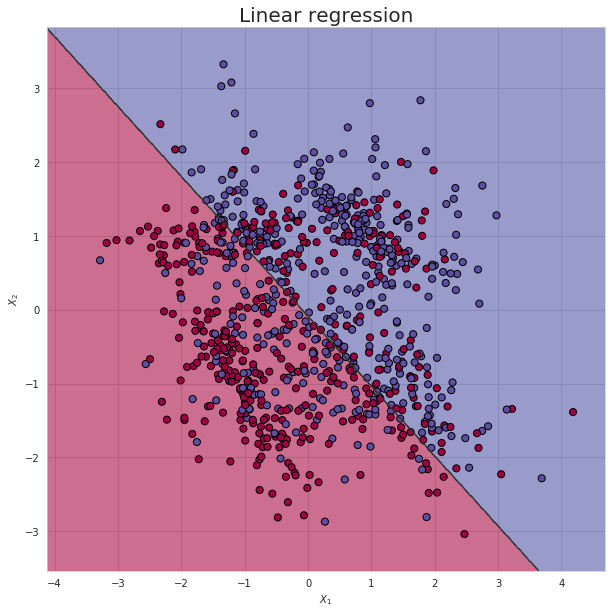

In [33]:
preds = regressor.predict(np.c_[XX.ravel(), YY.ravel()])
make_plot(XX, YY, preds, "Linear regression", '')

### Neural network without regularisation (high variance)

In [34]:
model = Sequential()
model.add(Dense(8, input_dim=2,activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)

In [35]:
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)
train_error = accuracy_score(y_train, y_train_pred)
test_error = accuracy_score(y_test, y_test_pred)
print("Train accuracy: " + str(train_error))
print("Test accuracy: " + str(test_error))

Train accuracy: 0.7144444444444444
Test accuracy: 0.7


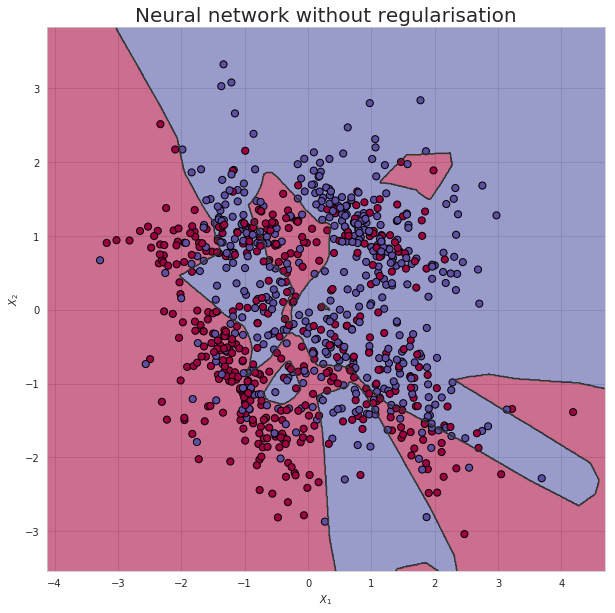

In [36]:
preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
make_plot(XX, YY, preds, "Neural network without regularisation", '')

### Neural network with regularisation (just right)

In [37]:
model = Sequential()
model.add(Dense(8, input_dim=2,activation='relu'))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)

In [38]:
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)
train_error = accuracy_score(y_train, y_train_pred)
test_error = accuracy_score(y_test, y_test_pred)
print("Train accuracy: " + str(train_error))
print("Test accuracy: " + str(test_error))

Train accuracy: 0.6888888888888889
Test accuracy: 0.78


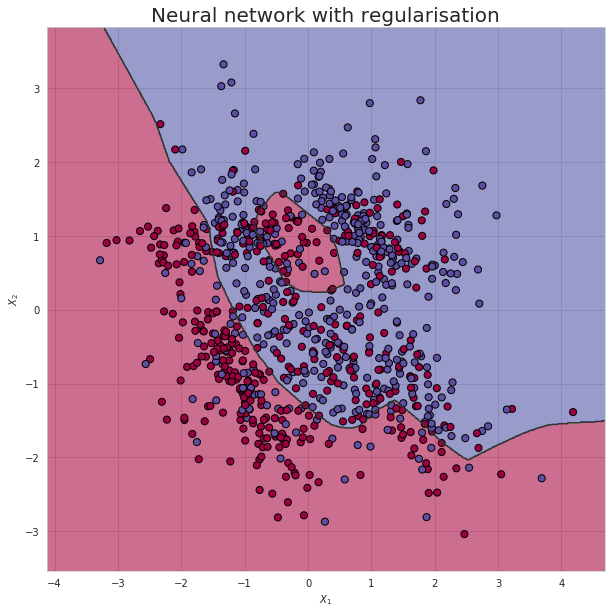

In [39]:
preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
make_plot(XX, YY, preds, "Neural network with regularisation", '')